In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import oracles
from methods import *
from plot_trajectory_2d import *
from tqdm import tqdm
from sklearn.datasets import load_svmlight_file

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2.2 Траектория градиентного спуска на квадратичной функции

In [180]:
def draw_pipeline(vary='k', steps=[1, 5, 10]):
    """
    vary:
        k - число обусловленности
        method - разные методы поиска шага
        x_0 - начальную точку
    """
    A_k_small = np.array([[1, 0], [0, 1]])
    A_k_medium = np.array([[10, 9], [9, 10]])
    A_k_big = np.array([[122, 123], [123, 122]])
    As = [A_k_small, A_k_medium, A_k_big]
    b = np.array([4, 7])
    x_0 = np.array([-5, -5])
    x_0_array = [np.random.randint(-6, 7, size=(2,)) for _ in range(5)]
    if vary == 'k':
        fig, axs = plt.subplots(3, 3, figsize=(10, 8), constrained_layout=True)
        for i in range(3):
            A = As[i]
            oracle = oracles.QuadraticOracle(A, b)
            for j in range(3):
                step = steps[j]
                ax = axs[i][j]
                gd = GradientDescent(oracle, x_0)
                gd.run(step)
                plot_levels(oracle.func, ax)
                plot_trajectory(oracle.func, ax, gd.hist['x'])
                ax.set_xlabel('x1')
                ax.set_ylabel('x2')
                k = np.round(np.linalg.cond(oracle.A), 1)
                ax.set_title(f'Число обусловленности: {k},\n количество шагов: {step}')
    elif vary == 'method':
        fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(10,10))
        axs = axs.flatten()
        oracle = oracles.QuadraticOracle(A_k_medium, b)
        step = steps[1]
        for ax, method in zip(axs, ['Wolfe', 'Armijo', 'Constant']):
            ls_tool = LineSearchTool(method=method)
            gd = GradientDescent(oracle, x_0, line_search_options=ls_tool)
            gd.run(step)
            plot_levels(oracle.func, ax)
            plot_trajectory(oracle.func, ax, gd.hist['x'])
            ax.set_xlabel('x1')
            ax.set_ylabel('x2')
            k = np.round(np.linalg.cond(oracle.A), 1)
            ax.set_title(f'Число обусловленности: {k}, количество шагов: {step}, метод: {method}')
    elif vary == 'x_0':
        fig, axs = plt.subplots(5, 3, figsize=(20, 20), constrained_layout=True)
        oracle = oracles.QuadraticOracle(A_k_medium, b)
        for i in range(5):
            for j in range(3):
                ax = axs[i][j]
                x_0 = x_0_array[i]
                step = steps[j]
                gd = GradientDescent(oracle, x_0)
                gd.run(step)
                plot_levels(oracle.func, ax)
                plot_trajectory(oracle.func, ax, gd.hist['x'])
                ax.set_xlabel('x1')
                ax.set_ylabel('x2')
                k = np.round(np.linalg.cond(oracle.A), 1)
                ax.set_title(f'Число обусловленности: {k},\n количество шагов: {step}, \n начальная точка: {x_0}')

## Число обусловленности

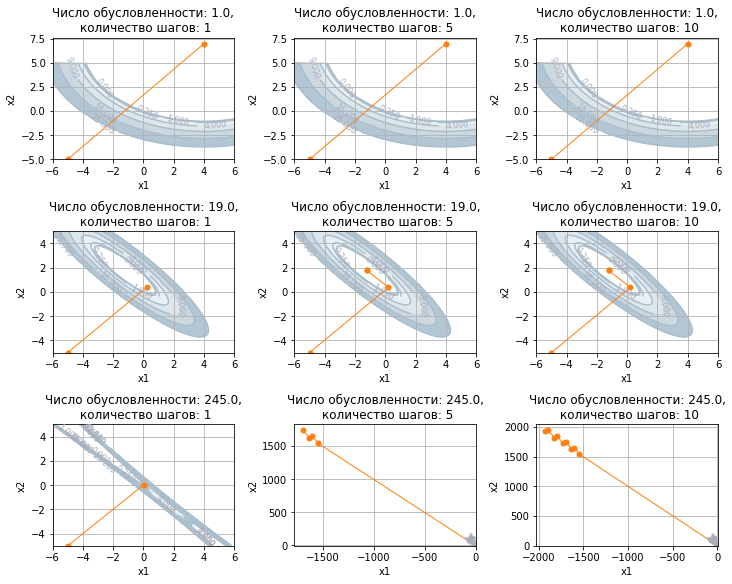

In [104]:
draw_pipeline()

**Вывод:** в общем случае чем больше число обусловленности, тем сложнее найти минимум функции и градиентному спуску требуется больше шагов

## Метод: Армихо и Вульф

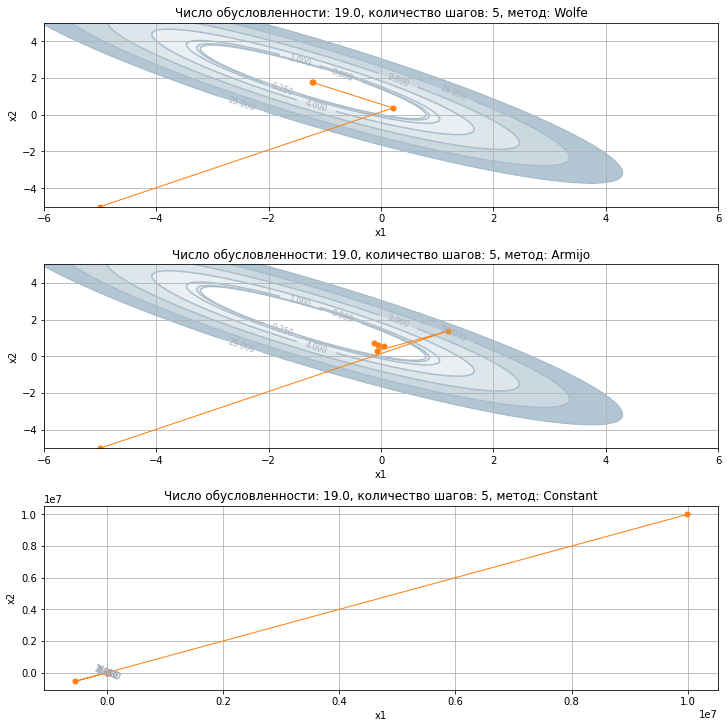

In [181]:
draw_pipeline('method')

**Вывод:** в данном конкретном примере метод Вульфа справляется лучше, чем метод Армихо. Константный шаг, кажется, сначала улетает далеко, но все же возвращается (но поведение ужасное)

## Начальная точка

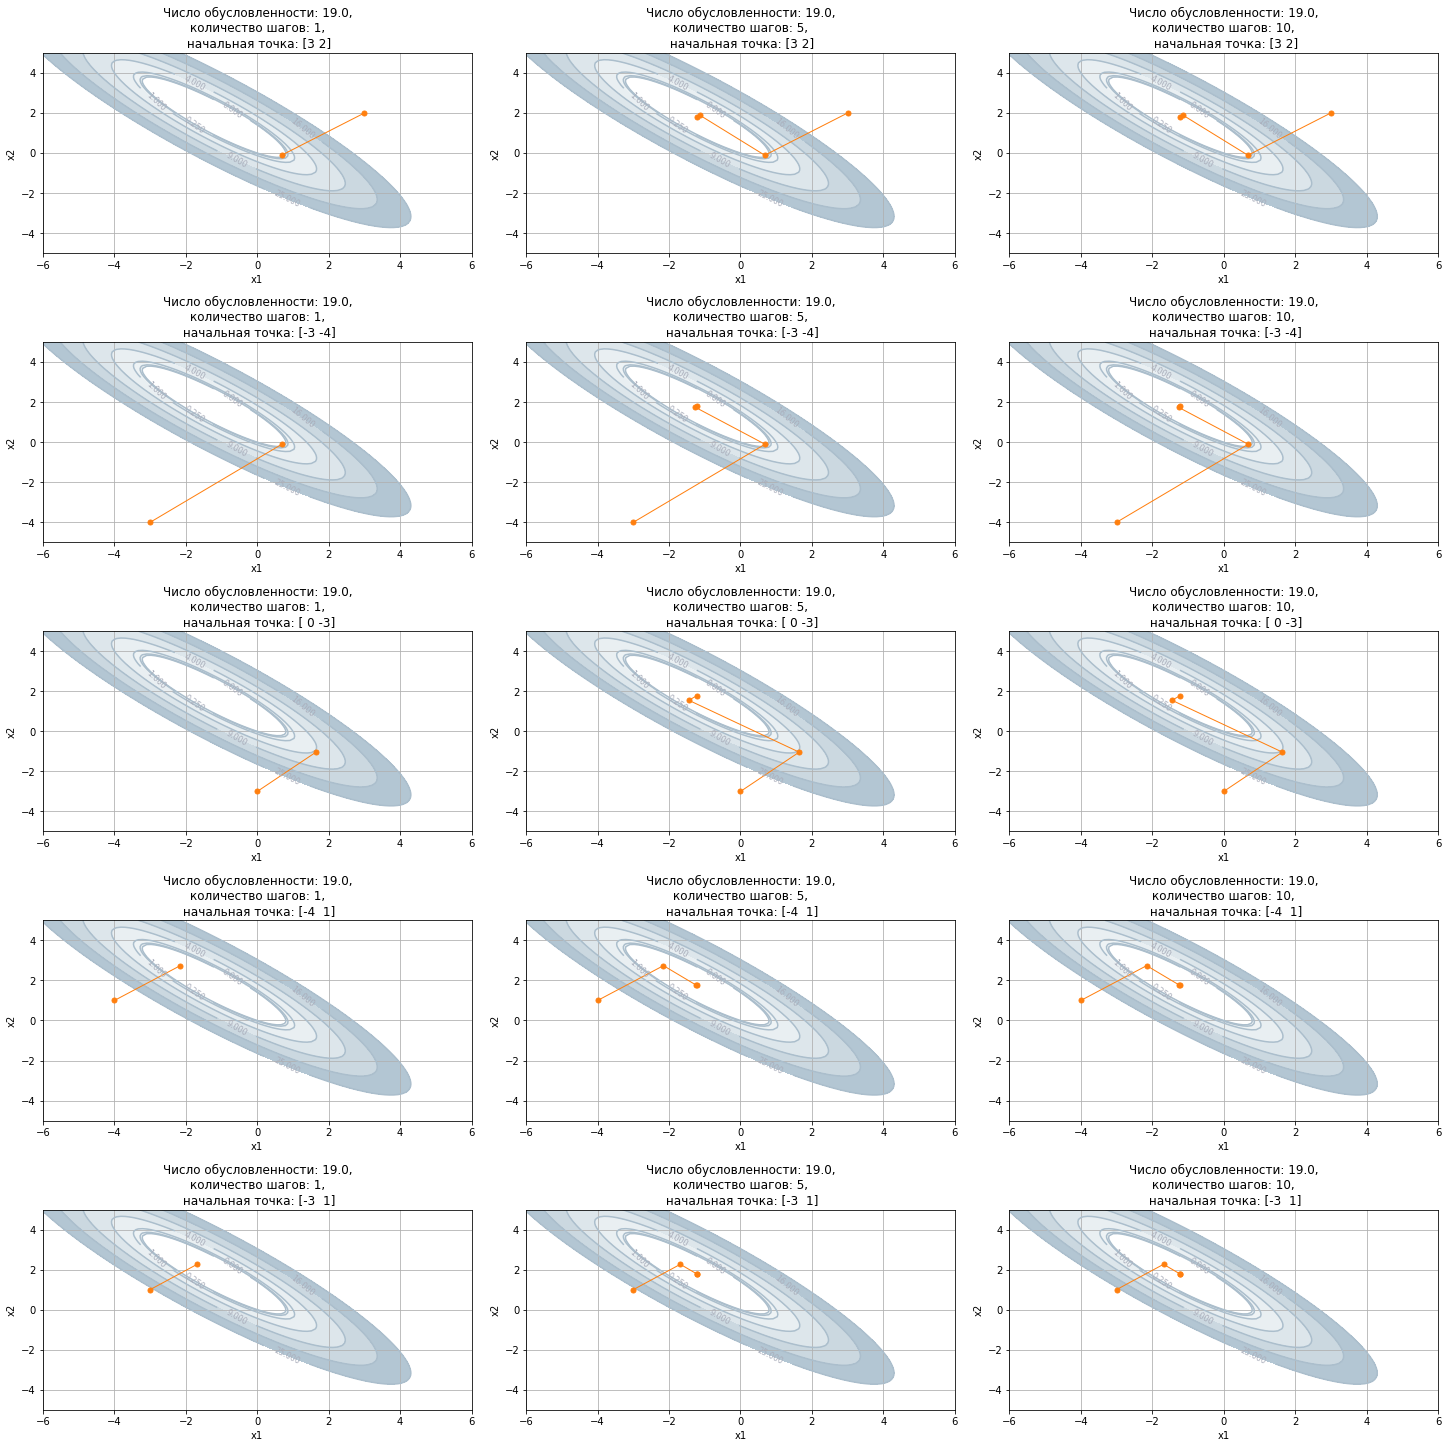

In [113]:
draw_pipeline(vary='x_0')

**Вывод:** от выбора начальной точки зависит число шагов градиентного спуска для поиска минимума

# 2.3 Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространства

In [114]:
def generate_task(n, k):
    numbers = np.random.randint(1, k, size=(n - 2, ))
    numbers = np.append(numbers, [1, k])
    A = np.diag(numbers)
    return A

In [163]:
def task_1(n, ax, num_ks=10, plots=5, eps=1e-10, color=None):
    def get_cmap(n, name='hsv'):
        return plt.cm.get_cmap(name, n)
    if color is None:
        cmap = get_cmap(50)
    else:
        cmap = lambda x: color
    b = np.zeros(n)
    k = np.linspace(2, 200, num_ks)
    for i in range(plots):
        curr_N = []
        for j in range(num_ks):
            A = generate_task(n, int(k[j]))
            oracle = oracles.QuadraticOracle(A, b)
            gd = GradientDescent(oracle, np.random.randint(-20, 20, size=(n, )), tolerance=eps)
            gd.run(1000000000)
            curr_N.append(len(gd.hist['x']))
        ax.plot(k, curr_N, c=cmap(i))
    ax.set_xlabel('k')
    ax.set_ylabel('N')
    ax.set_title(f'Количество шагов N для достижения \n точности {eps} \n при размерности пространства {n}')    

In [178]:
def task_2(ns=[10, 100, 200], colors=['r', 'g', 'b']):
    n = len(ns)
    assert n == len(colors)
    fig, ax = plt.subplots(figsize=(8, 8))
    for n, color in tqdm(zip(ns, colors)):
        task_1(n, ax, 19, color=color)
    legend_elements = [Line2D([0], [0], color=color, label=f'n = {n}') for n, color in zip(ns, colors)]
    ax.legend(handles=legend_elements)

Сначала зафиксируем n и будем варьировать k. Построим кривые количества шагов градиентного спуска N от k для достижения нужной точности

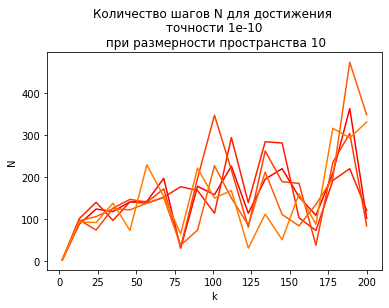

In [164]:
fig, ax = plt.subplots()
task_1(10, ax, 19)

**Вывод:** в целом, количество шагов до сходимости зависит от k прямо пропорционально

Теперь посмотрим, как изменится картина при увеличении размерности пространства n

5it [03:03, 36.73s/it]


CPU times: user 18min 54s, sys: 3min 21s, total: 22min 15s
Wall time: 3min 3s


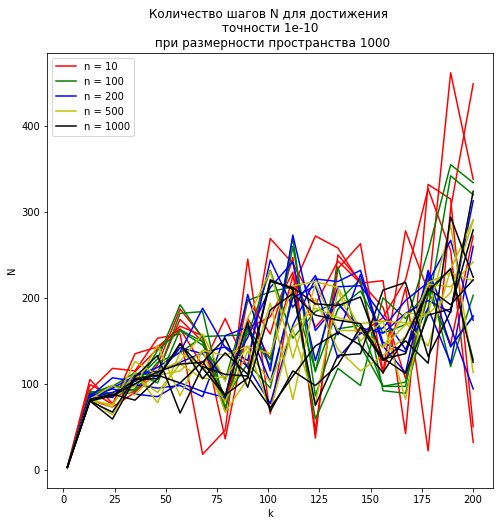

In [179]:
%%time

task_2(ns=[10, 100, 200, 500, 1000], colors=['r', 'g', 'b', 'y', 'k'])

## Выводы:

Как мы видим, количество итераций для достижения результата почти никак не зависит от размерности пространства N в случае квадратичной функции. Но, как и должно быть, по мере роста k растет необходимое число итераций GD

# Дополнительное задание на логистическую регрессию

In [191]:
data_9a9 = load_svmlight_file('datasets/a9a.txt')
data_gisette = load_svmlight_file('datasets/gisette_scale.bz2')
data_realsim = load_svmlight_file('datasets/real-sim.bz2')

In [209]:
def plot_task(data, title, regcoef=0.5, max_steps=1000):
    n, m = data.shape
    oracle = oracles.create_log_reg_oracle(data, np.zeros(n), regcoef)
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,10))
    methods = ['Wolfe', 'Armijo', 'Constant']
    colors = ['r', 'g', 'b']
    for color, method in tqdm(zip(colors, methods)):
        ls_tool = LineSearchTool(method=method)
        gd = GradientDescent(oracle, np.random.randn(m), line_search_options=ls_tool)
        gd.run(max_steps)
        hist = gd.hist
        n_iter = range(len(hist['x']))
        f_x = hist['func']
        ax.plot(n_iter, f_x, label=method, c=color)
    ax.set_xlabel('n_iter')
    ax.set_ylabel('F(x)')
    ax.set_title(f'{title}, regcoef: {regcoef}')
    ax.legend()

3it [00:05,  1.95s/it]


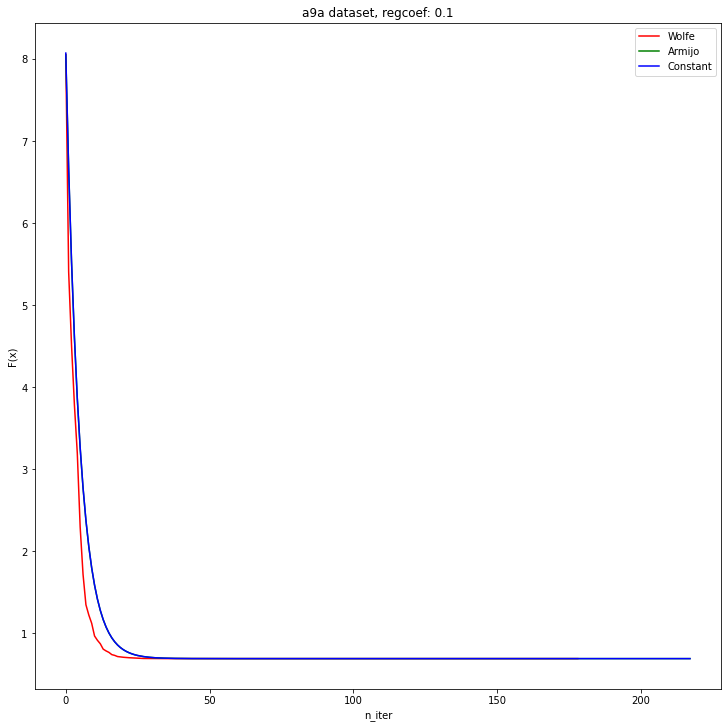

In [215]:
plot_task(data_9a9[0], 'a9a dataset', regcoef=0.1)

3it [01:50, 36.89s/it]


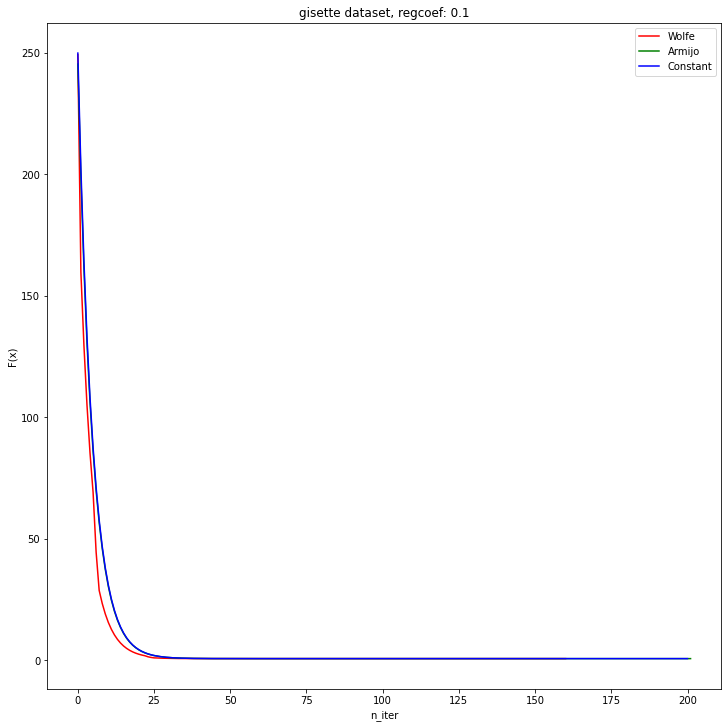

In [216]:
plot_task(data_gisette[0], 'gisette dataset', regcoef=0.1)

3it [00:21,  7.14s/it]


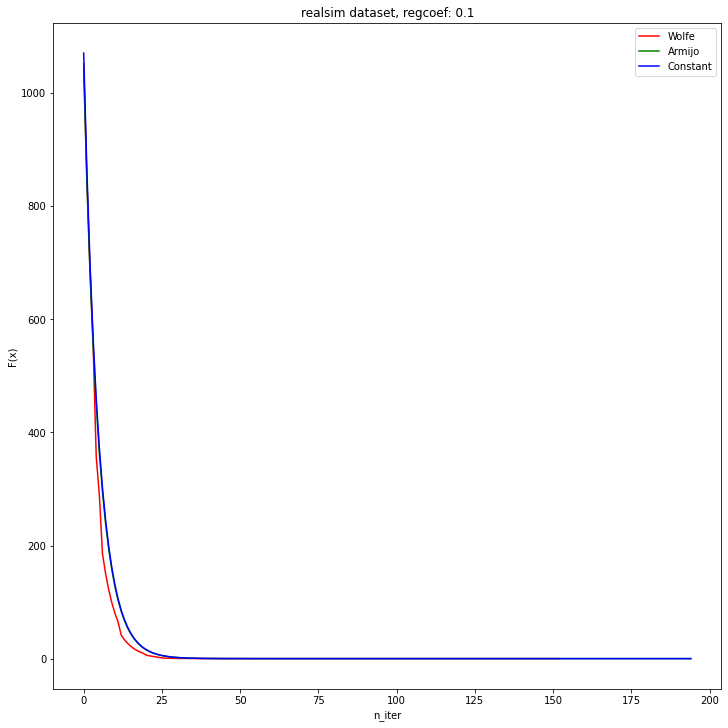

In [217]:
plot_task(data_realsim[0], 'realsim dataset', regcoef=0.1)

## Вывод

Как можно увидеть из графиков, на всех 3 задачах происходит сходимость, и на всех трех чуть лучше работает выбор шага методом Вульфа.